## Advanced Lane Finding
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

Creating a great writeup:
---
A great writeup should include the rubric points as well as your description of how you addressed each point.  You should include a detailed description of the code used in each step (with line-number references and code snippets where necessary), and links to other supporting documents or external references.  You should include images in your writeup to demonstrate how your code works with examples.  

All that said, please be concise!  We're not looking for you to write a book here, just a brief description of how you passed each rubric point, and references to the relevant code :). 

You're not required to use markdown for your writeup.  If you use another method please just submit a pdf of your writeup.

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!


## 1 - Compute Camera Calibration Matrix and Distortion Coeficients

In [8]:
import glob, pickle, cv2, glob, pickle
import numpy as np
import tracker
import matplotlib.pyplot as plt
%matplotlib inline

nx=9
ny=6

# prepare object points and image points from images
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

objpoints = []
imgpoints = []

images = glob.glob('./camera_cal/calibration*.jpg')

for index, filename in enumerate(images):
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    
    # find object and image points
    if ret == True:
        #print("working on image: ", index)
        objpoints.append(objp)
        imgpoints.append(corners)
        
        #display corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        write_name = './output_images/corners_found'+str(index)+'.jpg'
        cv2.imwrite(write_name, img)
        

img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[0], img.shape[1])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
dist_pickle= {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("./camera_cal/calibration_pickle.p", "wb"))
    

In [9]:
# Some helper functions

dist_pickle = pickle.load(open("./camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

ksize = 3

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(img, sobel_kernel=3, sthresh=(0, np.pi/2), vsthresh=(0, np.pi/2)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    v_channel = hls[:,:,2]
    v_binary = np.zeros_like(s_channel)
    v_binary[(v_channel >= sthresh[0]) & (v_channel <= sthresh[1])] = 1
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_binary ==1) & (v_binary==1)] = 1

    # Return the binary image
    return binary_output

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), max(0,int(center_width))]
    return output    

# Comparing images: Original checkerboard (calibration1.jpg)

As check, let us compare an original, distorted checkerboard versus an undistorted checkerboard - after all, distortion can be seen better on the checkerboards as compared to driving images:

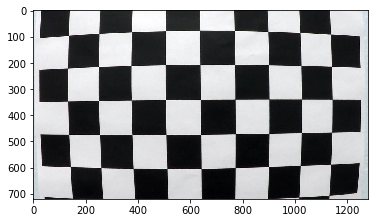

In [41]:
# plot distorted image
import matplotlib.pyplot as plt
%matplotlib inline

testimage = cv2.imread('./camera_cal/calibration1.jpg')
plt.imshow(testimage)

# Undistorted checkerboard:

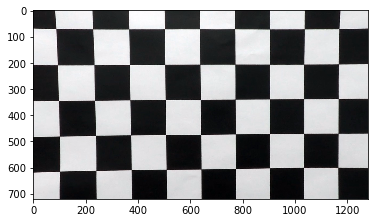

In [42]:
# plot undistorted image
testimage = cv2.undistort(testimage, mtx, dist, None, mtx)
plt.imshow(testimage)

## 2 & 3- Applying Distortion Correction on Test Images & Creating a Thresholded Binary Image

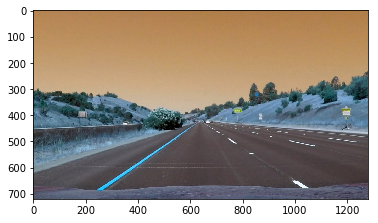

In [10]:
img = cv2.imread('test_images/straight_lines1.jpg')
plt.imshow(img)
plt.plot(850, 320, '.')

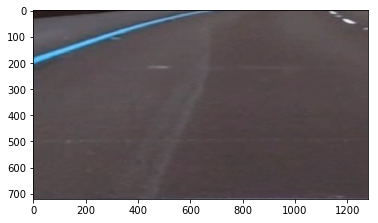

In [88]:
# read images
images = glob.glob('test_images/test*jpg')

# iterate over the images
for index, filename in enumerate(images):
    img = cv2.imread(filename)
    
    # undistort image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # create thresholded binary image
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh=(12, 255))
    grady = abs_sobel_thresh(img, orient='y', thresh=(25, 255))
    c_binary = color_threshold(img, sthresh=(100,255), vsthresh=(50,255))
    
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255
    
    img_size = (img.shape[1], img.shape[0])
    bot_width = .76
    mid_width = .08
    height_pct = .62
    bottom_trim = .935
    
    src = np.float32([[img.shape[1]*(.5-mid_width/2), img.shape[0]*height_pct], 
                      [img.shape[1]*(.5+mid_width/2), img.shape[0]*height_pct], 
                      [img.shape[1]*(.5+mid_width/2), img.shape[0]*bottom_trim],
                      [img.shape[1]*(.5-mid_width/2), img.shape[0]*bottom_trim]])
    
    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    
    offset = img_size[0]*.25
    dst = np.float32([[offset, 0], 
                      [img_size[0]-offset, 0], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]]])
    
    # perform transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # write image (index + 1 in order to make indices match from imput image to output image)
    write_name = './test_images/undistorted'+str(index+1)+'.jpg'
    cv2.imwrite(write_name, preprocessImage)
    write_name = './test_images/warped'+str(index+1)+'.jpg'
    cv2.imwrite(write_name, warped)
    
    #plot a sample image
    plt.imshow(warped, cmap='gray')